# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [346]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


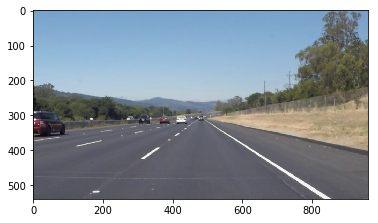

In [347]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [348]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def auto_canny(image, sigma=0.33):
    """
    Figures out high and low thresholds automatically.
    
    https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
    """

    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = canny(image, lower, upper)
 
    # return the edged image
    return edged

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def filter_bad_lines_using_x(img, lines):
    """
    Filters for bad lines using the x position.
    
    Assumes that left lane lines can't have an x coordinate further than half the image
    vertically and vice-versa for the right lane line.
    """
    imshape = img.shape
    newlines = []
    middle_x = int(imshape[1] / 2)
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Removes lines that are just dots
            if (x1 == x2 and y1 == y2):
                continue
            slope = ((y2-y1)/(x2-x1))
            if (slope < 0):
                # Removes left lane lines with an x coordinate past the middle of the image.
                if (x1 > middle_x or x2 > middle_x):
                    continue
            else:
                # Removes right lane lines with an x coordinate prior to the middle of the image.
                if (x1 < middle_x or x2 < middle_x):
                    continue
            newlines.append(line)
    return newlines

def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    Returns if the lines are valid
    """
    
    filter_by_x_lines = filter_bad_lines_using_x(img, lines)
    
    left_lines = []   # collection of left lane lines
    right_lines = []  # collection of right lane slopes
    left_slopes = []  # collection of left lane lines
    right_slopes = [] # collection of right lane slopes
    
    for line in filter_by_x_lines:
        for x1,y1,x2,y2 in line:
            if (x1 == x2 and y1 == y2):
                continue
            slope = ((y2-y1)/(x2-x1))
            if (slope == 0):
                continue
            if (slope < 0):
                left_slopes.append(slope)
                left_lines.append((x1,y1,x2,y2))
            else:
                right_slopes.append(slope)
                right_lines.append((x1,y1,x2,y2))
    
    imshape = img.shape

    y_top = 315 # Top of the lines y position
    y_bottom = imshape[0]  # Bottom of the lines y position
    
    if (np.size(left_lines) > 0):
        l_slope = np.median(left_slopes) # find median slope
        lb_x,lb_y,lt_x,lt_y = np.median(left_lines, axis=0) # find median line
        lb_y = y_bottom
        lb_x = int(lt_x-((lt_y-lb_y)/l_slope)) # using the median slope and median line find x at the y_bottom
        lt_y = y_top
        lt_x = int(lb_x+((lt_y-lb_y)/l_slope)) # using the median slope and modified line find the x at the y_top
        cv2.line(img, (lt_x, lt_y), (lb_x, lb_y), color, thickness)
        
    if (np.size(right_lines) > 0):
        r_slope = np.median(right_slopes) # find median slope
        rb_x,rb_y,rt_x,rt_y = np.median(right_lines, axis=0) # find median line
        rb_y = y_bottom
        rb_x = int(rt_x-((rt_y-rb_y)/r_slope)) # using the median slope and median line find x at the y_bottom
        rt_y = y_top
        rt_x = int(rb_x+((rt_y-rb_y)/r_slope)) # using the median slope and modified line find the x at the y_top
        cv2.line(img, (rt_x, rt_y), (rb_x, rb_y), color, thickness)
    
    # Are lines valid? currently checks if both left and right exist.
    is_valid = (np.size(left_lines) > 0) and (np.size(right_lines) > 0)
    return is_valid

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn as well if the lines are valid.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    is_valid = draw_lines(line_img, lines)
    return line_img, is_valid

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [349]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

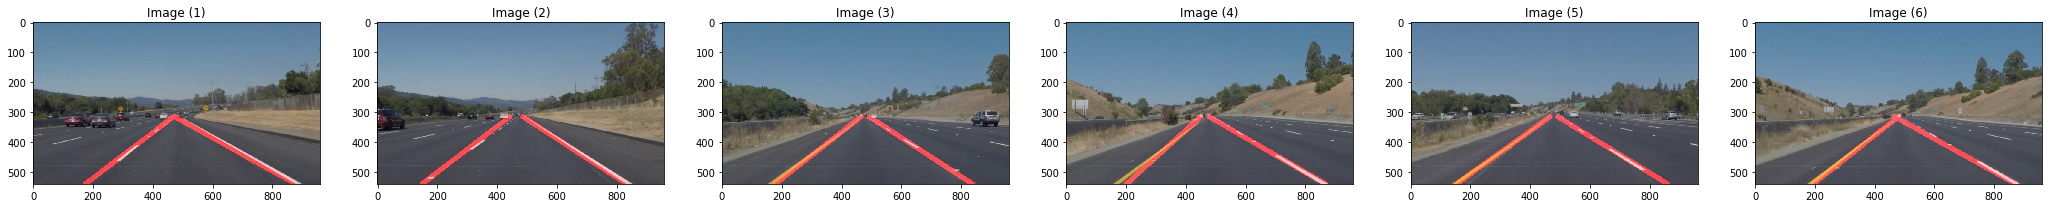

In [350]:
def draw_lane_lines(img):
    KERNEL_SIZE = 3                       # kernel size for Gaussian smoothing, must be an odd number (3, 5, 7...)
    MASK_BL_X_OFFSET = 165                # x position of where mask should start on the bottom left
    MASK_BR_X_OFFSET = 30                 # x position of where mask should end on the bottom right
    MASK_TOP = [(420, 315), (550, 315)]   # top line position of mask
    RHO = 1                               # distance resolution in pixels of the Hough grid
    THETA = np.pi/180                     # angular resolution in radians of the Hough grid
    THRESHOLD = 5                         # minimum number of votes (intersections in Hough grid cell)
    MIN_LINE_LEN = 20                     # minimum number of pixels making up a line
    MAX_LINE_GAP = 100                    # maximum gap in pixels between connectable line segments

    error_images = []                     # images in error used for debugging purposes

    gray = grayscale(img)
    blur = gaussian_blur(gray, KERNEL_SIZE)
    edges = auto_canny(blur)
    imshape = img.shape
    vertices = np.array([[(MASK_BL_X_OFFSET,imshape[0]),MASK_TOP[0], MASK_TOP[1], (imshape[1] - MASK_BR_X_OFFSET,imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    line_drawn, is_valid = hough_lines(masked_image, RHO, THETA, THRESHOLD, MIN_LINE_LEN, MAX_LINE_GAP)
    weighted = weighted_img(line_drawn, img)
    
    if (not is_valid):
        whole_image_vertices = np.array([[(0,imshape[0]),(0,0), (imshape[1],0), (imshape[1],imshape[0])]], dtype=np.int32)
        whole_image = region_of_interest(edges, whole_image_vertices)
        error_images.append(blur)         # image at blue
        error_images.append(whole_image)  # image after canny
        error_images.append(masked_image) # image with mask
    
    return weighted, error_images


#reading in an image
test_images = os.listdir("test_images/")

# This would print all the files and directories
out_ims = []
for test_image in test_images:
    img = mpimg.imread('test_images/' + test_image)
    line_drawn_image, error_images = draw_lane_lines(img)
    if (np.size(error_images) > 0):
        show_images(error_images)
        break

      # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    mpimg.imsave('test_images_output/' + test_image, line_drawn_image)
    out_ims.append(line_drawn_image)
show_images(out_ims)
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [351]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [352]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result, error_images = draw_lane_lines(image)
    if (np.size(error_images) > 0):
        show_images(error_images)

    return result

Let's try the one with the solid white lane on the right first ...

In [353]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#print('size:', ERROR_IMAGES.size())
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4













  0%|          | 0/222 [00:00<?, ?it/s]WARNING:py.warnings:/Users/bryan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in int_scalars













  5%|▍         | 10/222 [00:00<00:02, 92.56it/s]










  9%|▉         | 21/222 [00:00<00:02, 97.15it/s]










 14%|█▍        | 32/222 [00:00<00:01, 100.06it/s]










 19%|█▉        | 43/222 [00:00<00:01, 102.80it/s]










 23%|██▎       | 52/222 [00:00<00:01, 90.30it/s] 










 27%|██▋       | 60/222 [00:00<00:01, 86.65it/s]










 31%|███       | 68/222 [00:00<00:01, 83.92it/s]










 34%|███▍      | 76/222 [00:00<00:01, 82.18it/s]










 38%|███▊      | 84/222 [00:00<00:01, 78.87it/s]










 41%|████▏     | 92/222 [00:01<00:01, 73.49it/s]










 45%|████▌     | 101/222 [00:01<00:01, 75.60it/s]










 49%|████▉     | 109/222 [00:01<00:01, 76.39it/s]










 53%|█████▎    | 118/222 [00:01<00:01, 78.82it/s]




[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.33 s, sys: 581 ms, total: 2.91 s
Wall time: 3.06 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [354]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [355]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4













  0%|          | 0/682 [00:00<?, ?it/s]










  1%|▏         | 10/682 [00:00<00:06, 97.31it/s]










  3%|▎         | 21/682 [00:00<00:06, 99.51it/s]










  5%|▍         | 32/682 [00:00<00:06, 101.75it/s]










  6%|▋         | 43/682 [00:00<00:06, 103.45it/s]










  8%|▊         | 52/682 [00:00<00:07, 89.81it/s] 










  9%|▉         | 60/682 [00:00<00:07, 86.45it/s]










 10%|█         | 69/682 [00:00<00:07, 84.76it/s]










 11%|█▏        | 78/682 [00:00<00:07, 84.00it/s]










 13%|█▎        | 86/682 [00:00<00:07, 77.79it/s]










 14%|█▍        | 94/682 [00:01<00:08, 72.12it/s]










 15%|█▍        | 102/682 [00:01<00:08, 71.57it/s]










 16%|█▌        | 110/682 [00:01<00:07, 72.14it/s]










 17%|█▋        | 118/682 [00:01<00:07, 74.00it/s]










 19%|█▊        | 127/682 [00:01<00:07, 76.24it/s]










 20%|█▉        | 136/682 [00:01<00:06, 78.19it/s]










 21%|██▏       | 145/682 [00:01<00:06, 79.34it

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.43 s, sys: 1.67 s, total: 9.1 s
Wall time: 9.34 s


In [356]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [324]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4













  0%|          | 0/251 [00:00<?, ?it/s]WARNING:py.warnings:/Users/bryan/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in int_scalars













  2%|▏         | 4/251 [00:00<00:06, 35.62it/s]










  3%|▎         | 8/251 [00:00<00:06, 36.76it/s]










  5%|▌         | 13/251 [00:00<00:06, 38.18it/s]










  7%|▋         | 18/251 [00:00<00:05, 38.98it/s]










  9%|▉         | 23/251 [00:00<00:05, 39.51it/s]










 11%|█         | 27/251 [00:00<00:05, 38.81it/s]










 12%|█▏        | 31/251 [00:00<00:05, 38.49it/s]










 14%|█▍        | 35/251 [00:00<00:05, 36.81it/s]










 16%|█▌        | 39/251 [00:01<00:05, 35.59it/s]










 17%|█▋        | 43/251 [00:01<00:06, 34.01it/s]










 19%|█▊        | 47/251 [00:01<00:06, 32.22it/s]










 20%|██        | 51/251 [00:01<00:06, 31.64it/s]










 22%|██▏       | 55/251 [00:01<00:06, 29.31it/s]












[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.91 s, sys: 1.63 s, total: 9.54 s
Wall time: 9.93 s


In [325]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))